In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
from scipy.stats import gmean
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
plt.style.use('ggplot')

from palettable.tableau import GreenOrange_12 as palette
cmap = palette.hex_colors

from random import sample
from statistics import mean
import warnings
warnings.filterwarnings('ignore')

data_dir = './data/'


## Read and clean up somatic mutation data based on column and chromosome name

In [2]:
all_cnv = pd.read_csv(data_dir+'all_cnv.tsv', header=0, sep='\t', names=['Sample', 'Chromosome', 'Start', 'End', 'Num_Probes', 'Segment_Mean'] )
all_cnv[['Start', 'End', 'Num_Probes', 'Segment_Mean']] = all_cnv[['Start', 'End', 'Num_Probes', 'Segment_Mean']].convert_objects(convert_numeric=True)
all_cnv = all_cnv[all_cnv['Chromosome'].isin([str(i) for i in list(range(0,23))])]
#all_cnv['CN'] = all_cnv['Segment_Mean'].apply(lambda sm: (2**sm)*2)
all_cnv.head()

Sample Chromosome       Start       End  Num_Probes  \
0  TCGA-OR-A5KT-10A-01D-A29K-01          1   1642103.0   1688058          20   
1  TCGA-OR-A5KT-10A-01D-A29K-01          1   1688192.0  16149915        8139   
2  TCGA-OR-A5KT-10A-01D-A29K-01          1  16153497.0  16154239           8   
3  TCGA-OR-A5KT-10A-01D-A29K-01          1  16154966.0  25570830        5697   
4  TCGA-OR-A5KT-10A-01D-A29K-01          1  25571269.0  25696602          56   

   Segment_Mean  
0        0.8677  
1        0.0169  
2        1.1050  
3        0.0116  
4       -0.4542

## Read somatic mutation data

In [3]:
col_names = ['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'Ncbi_Build', 'Chrom', 'Start_Position', 'End_Position', 'Strand', 'Variant_Classification', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'Dbsnp_Rs', 'Dbsnp_Val_Status', 'Tumor_Sample_Barcode', 'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1', 'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1', 'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1', 'Match_Norm_Validation_Allele2', 'Verification_Status', 'Validation_Status', 'Mutation_Status', 'Sequencing_Phase', 'Sequence_Source', 'Validation_Method', 'Score', 'Bam_File', 'Sequencer', 'Tumor_Sample_UUID', 'Matched_Norm_Sample_UUID', 'File_Name', 'Archive_Name', 'Line_Number'] + (['']*11)
required_cols = ['Hugo_Symbol', 'Tumor_Sample_Barcode', 'Chrom', 'Start_Position', 'End_Position', 'Variant_Classification', 'Variant_Type', 'Archive_Name']
all_sm = pd.read_csv(data_dir+'all_sm.tsv', skiprows=1, header=None, sep='\t', names=col_names)
all_sm = all_sm[required_cols]
all_sm = all_sm[all_sm['Chrom'].isin([str(i) for i in list(range(0,23))])]
all_sm.head()

Hugo_Symbol          Tumor_Sample_Barcode Chrom Start_Position End_Position  \
0         A2M  TCGA-BJ-A0ZB-01A-11D-A10S-08    12        9264798      9264798   
1       A2ML1  TCGA-ET-A40S-01A-11D-A23M-08    12        8990110      8990111   
2        AACS  TCGA-EL-A4KG-01A-11D-A257-08    12      125612771    125612771   
3     AADACL2  TCGA-DO-A2HM-01B-11D-A22D-08     3      151475099    151475099   
4        AAK1  TCGA-EM-A3AR-01A-12D-A20C-08     2       69741609     69741609   

  Variant_Classification Variant_Type  \
0      Missense_Mutation          SNP   
1        Frame_Shift_Del          DEL   
2      Missense_Mutation          SNP   
3      Missense_Mutation          SNP   
4                 Silent          SNP   

                                        Archive_Name  
0  hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....  
1  hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....  
2  hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....  
3  hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....  
4  hgsc.bcm.edu_THCA.IlluminaGA_DNASeq_automated....

## Extract disease name from SM data

In [4]:
all_sm['Disease'] = all_sm['Archive_Name'].str.extract('\_(.*?)\.')   # Might not work for other archive names...
required_variant_types = ['Missense_Mutation', 'Frame_Shift_Del', 'Frame_Shift_Ins', 'Nonsense_mutation', 'In_Frame_Ins', 'In_Frame_Del']
all_sm = all_sm.loc[all_sm['Variant_Classification'].isin(required_variant_types)]

## Extract Patient Name for both datasets

In [5]:
all_sm['Patient'] = all_sm['Tumor_Sample_Barcode'].str.split('-').str.get(2)
all_cnv['Patient'] = all_cnv['Sample'].str.split('-').str.get(2)

In [6]:
def make_disease_dict(row):
    patients_diseases[row['Patient']] = row['Disease']

patients_diseases = {}
all_sm.apply(make_disease_dict, axis=1)
all_cnv['Disease'] = all_cnv.apply(lambda row: patients_diseases.get(row['Patient'], None), axis=1)

In [7]:
all_sm.groupby('Disease').count()[['Hugo_Symbol']]

Hugo_Symbol
Disease             
ACC            17562
CHOL            3965
COAD           79555
ESCA           33634
KICH            4788
KIRC           19046
KIRP           19415
LIHC           18527
OV              2568
PAAD           17514
PRAD            6106
READ           22488
SKCM          111358
STAD           94650
TGCT            8105
THCA            3019
THYM           15619
UCS             5397
UVM             1701

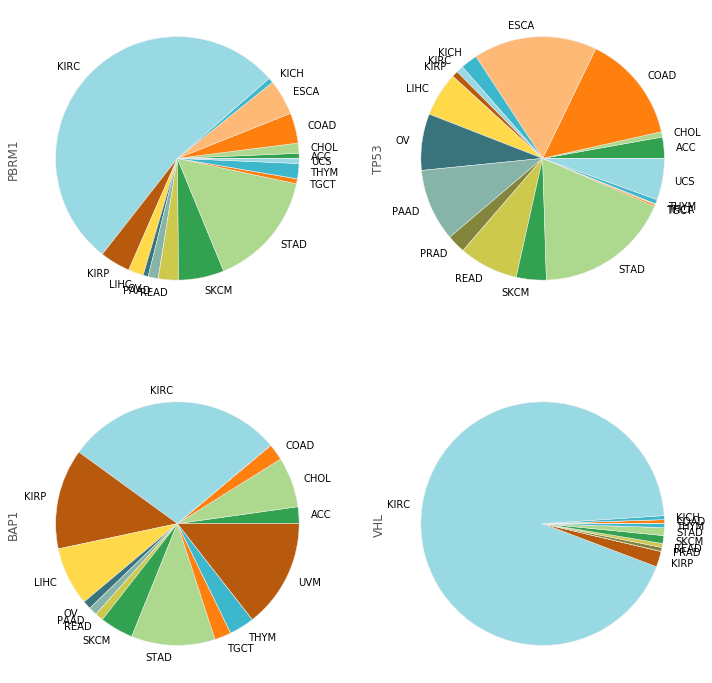

In [8]:
dis_counts = pd.DataFrame({'PBRM1':all_sm[all_sm['Hugo_Symbol'] == 'PBRM1'].groupby('Disease')['Disease'].count(), 
                        'BAP1':all_sm[all_sm['Hugo_Symbol'] == 'BAP1'].groupby('Disease')['Disease'].count(),
                        'TP53':all_sm[all_sm['Hugo_Symbol'] == 'TP53'].groupby('Disease')['Disease'].count(),
                        'VHL':all_sm[all_sm['Hugo_Symbol'] == 'VHL'].groupby('Disease')['Disease'].count(),
                        'BRAF':all_sm[all_sm['Hugo_Symbol'] == 'BRAF'].groupby('Disease')['Disease'].count(),
                        'KRAS':all_sm[all_sm['Hugo_Symbol'] == 'KRAS'].groupby('Disease')['Disease'].count()})

fig, axes = plt.subplots(nrows=2, ncols=2)
dis_counts['PBRM1'].plot(ax=axes[0,0], colors=cmap, kind='pie'); axes[0,0]
dis_counts['BAP1'].plot(ax=axes[1,0], colors=cmap, kind='pie'); axes[1,0]
dis_counts['TP53'].plot(ax=axes[0,1], colors=cmap, kind='pie'); axes[0,1]
dis_counts['VHL'].plot(ax=axes[1,1], colors=cmap, kind='pie'); axes[1,1]

fig.savefig('charts/all_pie.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/all_pie.png', bbox_inches='tight', format='png')

In [9]:
all_cnv['length'] = all_cnv['End'] - all_cnv['Start']
original_all_cnv = all_cnv.copy()
all_cnv = all_cnv.loc[all_cnv['Num_Probes'] >= 10]     # NUM_PROBES CITATION!
bottom_quantile_length = original_all_cnv['length'].quantile(.25) # Higher threshold gives more predictive

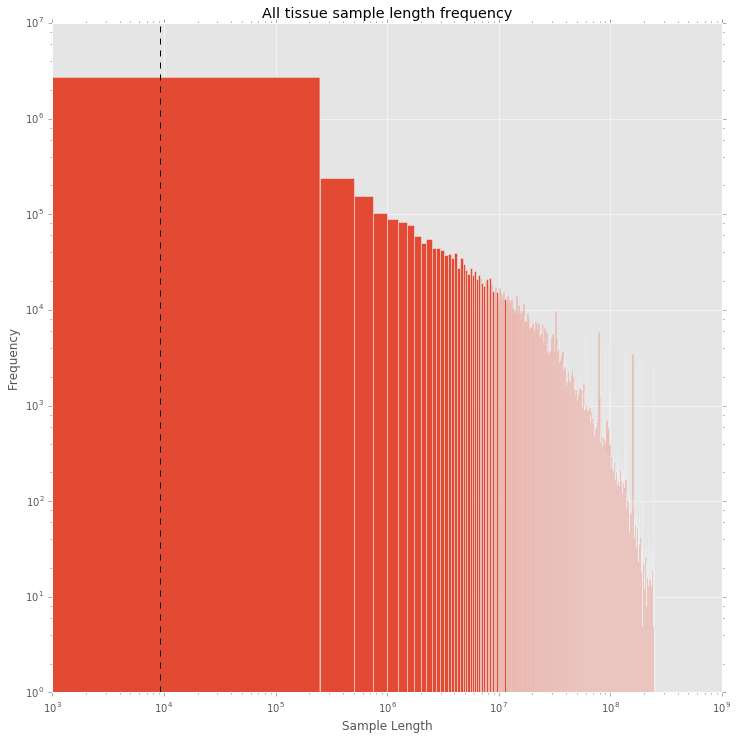

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1)
original_all_cnv['length'].plot(kind='hist', logy=True, logx=True, bins=1000, ax=axes)
axes.axvline(bottom_quantile_length, color='k', linestyle='--')
axes.set_xlabel('Sample Length')
axes.set_title('All tissue sample length frequency')

fig.savefig('charts/all_sample_length_freq.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/all_sample_length_freq.png', bbox_inches='tight', format='png')
fig.show()

## Get absolute segment mean values

In [11]:
all_cnv['Abs_Segment_Mean'] = abs(all_cnv['Segment_Mean'])

## Filter by Segment Length

In [12]:
print('Bottom Quantile Length', bottom_quantile_length)
print('Total Number of samples', len(all_cnv))
all_cnv = all_cnv.loc[all_cnv['length'] > bottom_quantile_length]
print('Number of samples above bottom quantile', len(all_cnv))
all_cnv.describe()

Bottom Quantile Length 9284.0
Total Number of samples 4217792
Number of samples above bottom quantile 3958012


Start           End    Num_Probes  Segment_Mean        length  \
count  3.958012e+06  3.958012e+06  3.958012e+06  3.958012e+06  3.958012e+06   
mean   6.533872e+07  7.800666e+07  7.395729e+03 -8.348226e-03  1.266794e+07   
std    5.701567e+07  5.887575e+07  1.504770e+04  5.068120e-01  2.681362e+07   
min    5.260000e+02  2.288100e+04  1.000000e+01 -7.257600e+00  9.285000e+03   
25%    1.939517e+07  3.001144e+07  7.600000e+01 -7.510000e-02  1.604720e+05   
50%    4.965812e+07  6.471804e+07  1.216000e+03  6.600000e-03  2.141336e+06   
75%    1.032413e+08  1.151736e+08  7.592000e+03  1.387000e-01  1.246370e+07   
max    2.492018e+08  2.492244e+08  1.501700e+05  6.230700e+00  2.491627e+08   

       Abs_Segment_Mean  
count      3.958012e+06  
mean       2.903966e-01  
std        4.154490e-01  
min        0.000000e+00  
25%        1.430000e-02  
50%        1.104000e-01  
75%        4.500000e-01  
max        7.257600e+00

In [13]:
## Average segment mean 

In [14]:
disease_box_sm = all_cnv[['Patient', 'Disease', 'Segment_Mean']].groupby(['Patient', 'Disease'], axis=0).aggregate(np.mean)
disease_box_sm_abs = all_cnv[['Patient', 'Disease', 'Abs_Segment_Mean']].groupby(['Patient', 'Disease'], axis=0).aggregate(np.mean)
disease_box_cn = disease_box_sm.applymap(lambda x: (2**x)*2)
disease_box_cn.columns = ['CN']
disease_box_sm = disease_box_sm.reset_index().pivot('Patient', 'Disease', 'Segment_Mean').reset_index()
disease_box_sm_abs = disease_box_sm_abs.reset_index().pivot('Patient', 'Disease', 'Abs_Segment_Mean').reset_index()
disease_box_cn = disease_box_cn.reset_index().pivot('Patient', 'Disease', 'CN').reset_index()



In [15]:
columns = disease_box_sm_abs.describe().transpose().sort('mean').index
disease_box_sm_abs = disease_box_sm_abs[columns]
columns = disease_box_cn.describe().transpose().sort('mean').index
disease_box_cn = disease_box_cn[columns]

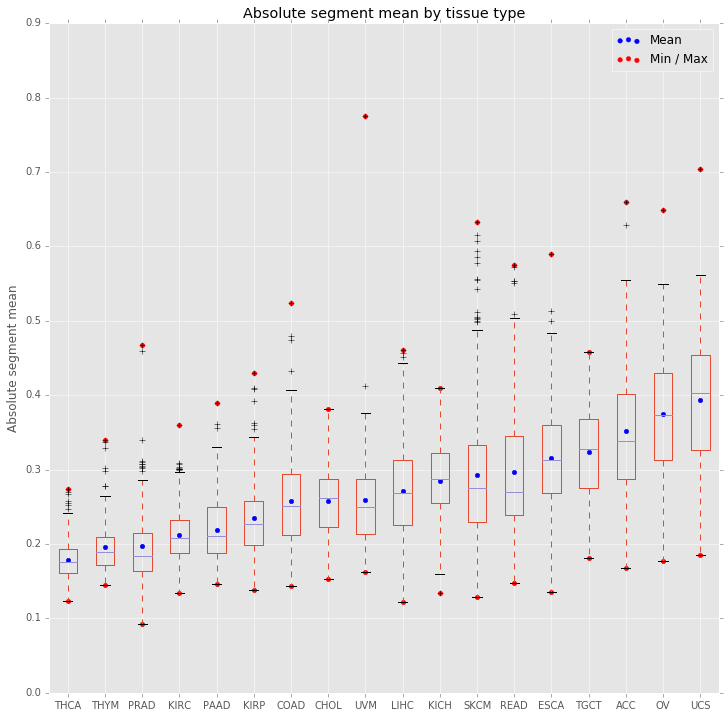

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1)

disease_box_sm_abs.boxplot(sym='b+', ax=axes)
axes.set_ylabel('Absolute segment mean')
axes.set_title('Absolute segment mean by tissue type')

means = disease_box_sm_abs.describe().iloc[[1]].values.tolist()[0]
mins = disease_box_sm_abs.describe().iloc[[3]].values.tolist()[0]
maxs = disease_box_sm_abs.describe().iloc[[7]].values.tolist()[0]
plt.scatter(range(1,19), means, color='blue', label='Mean')
plt.scatter(range(1,19), mins, color='red',label='Min / Max')
plt.scatter(range(1,19), maxs, color='red')

plt.legend()
fig.savefig('charts/all_disease_box_asm.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/all_disease_box_asm.png', bbox_inches='tight', format='png')

Disease        UVM        THYM       CHOL        PRAD        PAAD        THCA  \
count    80.000000  121.000000  35.000000  171.000000  146.000000  399.000000   
mean      1.936084    1.941046   1.951594    1.954622    1.959878    1.960205   
std       0.063147    0.041911   0.055496    0.068202    0.056667    0.048201   
min       1.768433    1.804030   1.843369    1.667016    1.806208    1.836918   
25%            NaN         NaN        NaN         NaN         NaN         NaN   
50%            NaN         NaN        NaN         NaN         NaN         NaN   
75%            NaN         NaN        NaN         NaN         NaN         NaN   
max       2.077194    2.019977   2.082531    2.147411    2.147605    2.125527   

Disease       KICH        COAD        READ        KIRP        ACC        KIRC  \
count    66.000000  269.000000  116.000000  168.000000  92.000000  417.000000   
mean      1.960362    1.968974    1.973427    1.976757   1.977155    1.981135   
std       0.048594    0.062998    0.080313    0.061485   0.101778    0.060904   
min       1.827495    1.763101    1.716284    1.865888   1.807004    1.804399   
25%            NaN         NaN         NaN         NaN        NaN         NaN   
50%            NaN         NaN         NaN         NaN        NaN         NaN   
75%            NaN         NaN         NaN         NaN        NaN         NaN   
max       2.160091    2.135421    2.287066    2.175212   2.463145    2.202190   

Disease        LIHC        SKCM        TGCT        ESCA        UCS         OV  
count    196.000000  343.000000  131.000000  183.000000  57.000000  89.000000  
mean       1.985983    2.010072    2.010335    2.012417   2.021602   2.028325  
std        0.084896    0.120061    0.070043    0.090970   0.112108   0.074571  
min        1.777578    1.576540    1.814294    1.670531   1.686200   1.876515  
25%             NaN         NaN         NaN         NaN        NaN        NaN  
50%             NaN         NaN         NaN         NaN        NaN        NaN  
75%             NaN         NaN         NaN         NaN        NaN        NaN  
max        2.242566    2.577922    2.226272    2.238786   2.265313   2.216103

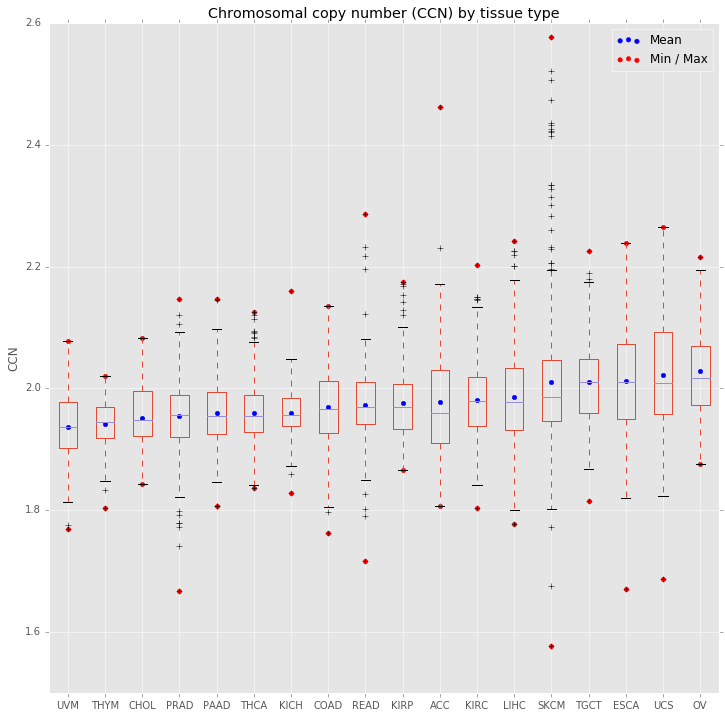

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=1)

disease_box_cn.boxplot(sym='b+', ax=axes)
axes.set_ylabel('CCN')
axes.set_title('Chromosomal copy number (CCN) by tissue type')
axes.set_ylim(1.5, 2.6)
means = disease_box_cn.describe().iloc[[1]].values.tolist()[0]
mins = disease_box_cn.describe().iloc[[3]].values.tolist()[0]
maxs = disease_box_cn.describe().iloc[[7]].values.tolist()[0]
plt.scatter(range(1,19), means, color='blue', label='Mean')
plt.scatter(range(1,19), mins, color='red',label='Min / Max')
plt.scatter(range(1,19), maxs, color='red')

plt.legend()
fig.savefig('charts/all_disease_box_ccn.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/all_disease_box_ccn.png', bbox_inches='tight', format='png')

disease_box_cn.describe()

### Select Genes

In [18]:
gene_count = all_sm.groupby('Hugo_Symbol').count().reset_index()
gene_count = gene_count[['Hugo_Symbol', 'Tumor_Sample_Barcode']]
gene_count.columns = ['Gene', 'Count']

gene_list = 'VHL PBRM1 SETD2 BAP1 PTEN RANBP2 PIK3CA ATM AKAP9 TP53'.split(' ')
genes = gene_count[(gene_count['Gene'].isin(gene_list))]

g_count = int(genes[['Gene']].count())

genes

Gene  Count
472     AKAP9    142
1134      ATM    177
1330     BAP1     90
11638   PBRM1    149
12056  PIK3CA    246
12889    PTEN    134
13187  RANBP2    117
14296   SETD2    131
16625    TP53    853
17429     VHL    191

##  Make subset for disease tissue

In [19]:
tissue_cnv = all_cnv[all_cnv['Disease'] == 'KIRC']
non_tissue_cnv = all_cnv[all_cnv['Disease'] != 'KIRC']

print(non_tissue_cnv.count())
print(non_tissue_cnv.groupby('Patient').count().count())

Sample              3649213
Chromosome          3649213
Start               3649213
End                 3649213
Num_Probes          3649213
Segment_Mean        3649213
Patient             3649213
Disease             2119458
length              3649213
Abs_Segment_Mean    3649213
dtype: int64
Sample              4107
Chromosome          4107
Start               4107
End                 4107
Num_Probes          4107
Segment_Mean        4107
Disease             4107
length              4107
Abs_Segment_Mean    4107
dtype: int64


## Estimating probability of aneuploidy by mutation 

In [20]:
from scipy.stats import ttest_ind, t

def t_test_stats(population, img_name_prepend):

    def ttest(control, mut, gene):
        p_value = list(ttest_ind(mut['Abs_Segment_Mean'], control['Abs_Segment_Mean']))
        return p_value

    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            if point['y'] > 0.05:
                ax.text(point['x'], point['y'], str(point['val']), color='black')
            else:
                ax.text(point['x'], point['y'], str(point['val']), color='green')

    t_dict = {}
    smm = {}
    for gene in genes['Gene']:
        patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
        control = population[~population['Patient'].isin(patients)]
        mut = population[population['Patient'].isin(patients)]
        
        smm[gene] = [mut['Abs_Segment_Mean'].mean()]
        t_dict[gene] = ttest(control, mut, gene)

    gene_ttest = pd.DataFrame(t_dict)
    gene_ttest = gene_ttest.transpose().reset_index()
    gene_ttest.columns = ['gene', 'sm_t-statistic', 'sm_p-value']
    gene_mean = pd.DataFrame(smm)
    gene_mean = gene_mean.transpose().reset_index()
    gene_mean.columns = ['gene', 'abs_segment_mean']
    gene_stats = pd.merge(gene_ttest, gene_mean)
    gene_stats = gene_stats.set_index('gene').reset_index()
    gene_stats = gene_stats.sort('sm_p-value', ascending=True)
    gene_stats['indices'] = [i for i in range(1,11)]
    gene_stats['Corrected_P'] = gene_ttest['sm_p-value'] * gene_stats['indices']

    return gene_stats

In [21]:
population = tissue_cnv.groupby('Patient', as_index=False).mean()
tissue_stats = t_test_stats(population, img_name_prepend='KIRC')
tissue_p = tissue_stats[['gene', 'Corrected_P']]
tissue_sm = tissue_stats[['gene', 'abs_segment_mean']]


In [22]:
population = non_tissue_cnv.groupby('Patient', as_index=False).mean()
non_tissue_stats = t_test_stats(population, img_name_prepend='Non-KIRC')
non_tissue_p = non_tissue_stats[['gene', 'Corrected_P']]
non_tissue_sm = non_tissue_stats[['gene', 'abs_segment_mean']]


In [23]:
population = all_cnv.groupby('Patient', as_index=False).mean()
all_tissue_stats = t_test_stats(population, img_name_prepend='All')
all_tissue_p = all_tissue_stats[['gene', 'Corrected_P']]
all_tissue_sm = all_tissue_stats[['gene', 'abs_segment_mean']]

In [24]:
tissue_m = pd.merge(tissue_p, non_tissue_p, on='gene')
all_p = pd.merge(tissue_m, all_tissue_p, on='gene')
all_p.columns = ['Gene', 'KIRC', 'Non-KIRC', 'All tissues']
all_p.sort('Gene')

tissue_sm_m = pd.merge(tissue_sm, non_tissue_sm, on='gene')
all_tissue_sm = pd.merge(tissue_sm_m, all_tissue_sm, on='gene')
all_tissue_sm.columns = ['Gene', 'KIRC', 'Non-KIRC', 'All tissues']
all_tissue_sm.sort('Gene')

Gene      KIRC  Non-KIRC  All tissues
1   AKAP9  0.223313  0.261026     0.257217
6     ATM  0.215884  0.252354     0.249182
4    BAP1  0.216638  0.259005     0.243491
0   PBRM1  0.219317  0.266174     0.235717
7  PIK3CA  0.214919  0.260858     0.257555
9    PTEN  0.211157  0.261491     0.254467
5  RANBP2  0.205340  0.269741     0.262274
2   SETD2  0.218513  0.258296     0.246570
3    TP53  0.225063  0.302146     0.301285
8     VHL  0.211747  0.209844     0.211659

In [25]:
from random import sample
from statistics import mean

def t_test_plot(population, gene_name, image_name_prepend, samples = 2000, sample_size = 10):
    
    patients = all_sm[all_sm['Hugo_Symbol'] == gene_name]['Patient'].unique()
    control = population[~population['Patient'].isin(patients)]
    mut = population[population['Patient'].isin(patients)]
    
    control_sm  = control['Abs_Segment_Mean']
    mut_sm = mut['Abs_Segment_Mean']
    control_sm_hist, mut_sm_hist = [], []
    
    i = 0
    while i < samples:
        control_sm_hist.append(mean(sample(list(control_sm), sample_size)) - mean(sample(list(control_sm), sample_size)))
        mut_sm_hist.append(mean(sample(list(mut_sm),sample_size)) - mean(sample(list(control_sm), sample_size)))
        i = i + 1
            
    hists = pd.DataFrame({'csm':control_sm_hist, 'msm':mut_sm_hist})
        
    m_sm = mean(mut_sm) - mean(control_sm)
    
    bins = 100
    fig, axes = plt.subplots(nrows=1, ncols=1)
    
    hists['csm'].plot(ax=axes, bins=bins, kind='hist', alpha=0.3, label='Control'); 
    hists['msm'].plot(ax=axes, bins=bins, kind='hist', alpha=0.3, label='Mutation');
    axes.set_title('%s Tissue %s Sampled Segment Mean' % (image_name_prepend, gene_name));
    axes.axvline(m_sm, color='k', linestyle='--')
    axes.set_xlabel('%s tissue absolute segment mean' % image_name_prepend)
    sm_t_vals = 'T-Statistic:\n%s\n\nP-Value:\n%s' % ttest_ind(control_sm, mut_sm)
    fig.text(0.88, 0.8, sm_t_vals, horizontalalignment='right', verticalalignment='top', fontdict=None)
    axes.legend()
    
    fig.savefig('charts/%s_%s_fig.pdf' % (image_name_prepend.lower(), gene_name), bbox_inches='tight', format='pdf')
    fig.savefig('charts/%s_%s_fig.png' % (image_name_prepend.lower(), gene_name), bbox_inches='tight', format='png')


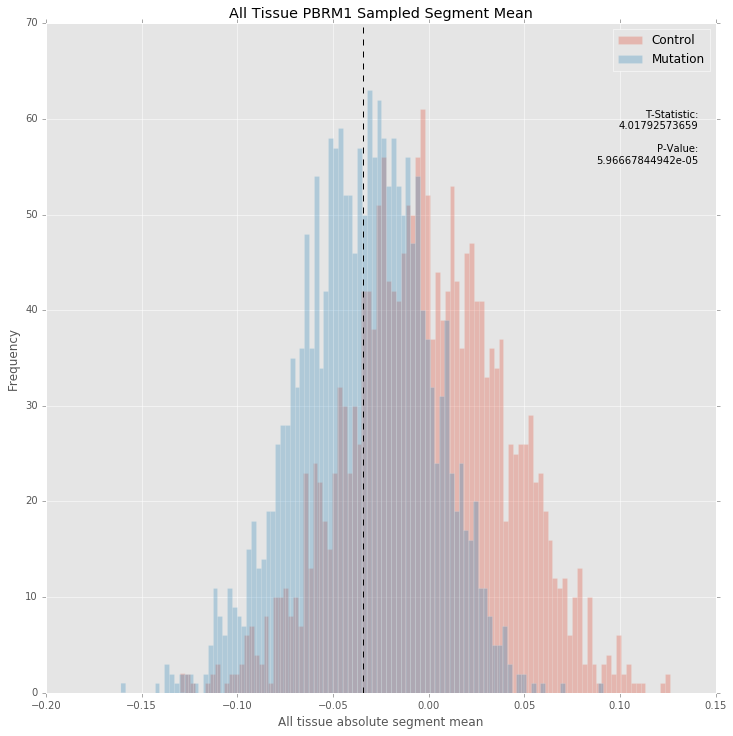

In [26]:
population = all_cnv.groupby('Patient', as_index=False).mean()
t_test_plot(population, gene_name='PBRM1', image_name_prepend='All')

### Segment arm data

In [27]:
def add_to_centromere_dict(row):
    if 'p' in row['arm']:
        arm_dict[row['chrom']] = row['stop']
arm_dict = {}
centromeres = pd.read_csv(data_dir+'centromeres.txt', sep='\t', names=['chrom', 'start', 'stop', 'arm', 'acen'])
centromeres['chrom'] = centromeres['chrom'].apply(func=lambda x: x.replace('chr',''))

In [28]:
def get_arm_data(cnv_data):

    def find_arm(row):
        if row['End'] <= arm_dict[row['Chromosome']]:
            return row['Chromosome'] + 'p'
        else:
            return row['Chromosome'] + 'q'

    centromeres.apply(add_to_centromere_dict, axis=1)
    cnv_data['arm'] = cnv_data.apply(find_arm, axis=1)
    arm_names = []
    missing_arms = ['13p', '14p', '15p', '22p']
    for i in range(1, 23):
        for j in ['p', 'q']:
            arm = str(i)+j
            if arm not in missing_arms:
                arm_names.append(str(i)+j) 
    arm_data = cnv_data[['Patient', 'arm', 'Segment_Mean']].groupby(['Patient', 'arm'], axis=0).aggregate(np.mean)
    arm_data = arm_data.applymap(lambda x: (2**x)*2)
    arm_data = arm_data.reset_index().pivot('Patient', 'arm', 'Segment_Mean').reset_index()
    arm_data = arm_data[['Patient'] + arm_names]
    arm_data = arm_data.fillna(2)
    return (arm_data, arm_names)

In [29]:
pd.options.display.max_columns = 999

In [30]:
all_arm_data, all_arm_names = get_arm_data(all_cnv)
all_arm_data.describe()

arm             1p           1q           2p           2q           3p  \
count  4524.000000  4524.000000  4524.000000  4524.000000  4524.000000   
mean      1.964848     2.055452     1.973009     2.008874     1.900891   
std       0.224326     0.286531     0.292289     0.191990     0.264429   
min       1.018674     1.202184     0.959929     0.797745     0.507338   
25%       1.823220     1.868971     1.790272     1.912449     1.754404   
50%       1.957525     2.022733     1.983086     2.005097     1.904205   
75%       2.092713     2.183411     2.137044     2.095263     2.034165   
max       3.650940     5.418299     5.589721     3.636968     6.386876   

arm             3q           4p           4q           5p           5q  \
count  4524.000000  4524.000000  4524.000000  4524.000000  4524.000000   
mean      2.062908     1.940700     1.914127     2.087078     1.956764   
std       0.269557     0.311926     0.204736     0.373537     0.240151   
min       0.877558     0.632845     0.635318     0.890531     0.731220   
25%       1.904125     1.745539     1.806567     1.866222     1.817927   
50%       2.031691     1.940924     1.935709     2.038418     1.966664   
75%       2.174905     2.132249     2.034583     2.249917     2.087263   
max       4.136852     4.171516     4.925834     4.914024     3.669107   

arm             6p           6q           7p           7q           8p  \
count  4524.000000  4524.000000  4524.000000  4524.000000  4524.000000   
mean      2.057033     1.900660     2.139722     2.104618     1.895362   
std       0.320017     0.235850     0.347941     0.260212     0.314767   
min       0.951472     0.898200     0.859042     1.201392     0.278860   
25%       1.851003     1.762959     1.976349     1.939353     1.700142   
50%       2.014603     1.908402     2.085527     2.076685     1.903595   
75%       2.215674     2.043835     2.273893     2.233020     2.086165   
max       5.146887     4.075575     7.797807     4.721147     4.320658   

arm             8q           9p           9q          10p          10q  \
count  4524.000000  4524.000000  4524.000000  4524.000000  4524.000000   
mean      2.200948     1.879525     1.969682     2.014622     1.960543   
std       0.391513     0.315021     0.203496     0.267073     0.219600   
min       1.107668     0.354134     0.735813     0.456251     0.786308   
25%       1.985348     1.698022     1.869912     1.926387     1.850726   
50%       2.070510     1.887720     1.990743     2.004858     1.976089   
75%       2.313709     2.062352     2.067336     2.084271     2.081638   
max       5.382607     3.841403     3.120283     4.740965     3.586265   

arm            11p          11q          12p          12q          13q  \
count  4524.000000  4524.000000  4524.000000  4524.000000  4524.000000   
mean      1.951549     1.990142     2.106583     2.064170     1.968492   
std       0.246557     0.267696     0.505859     0.244055     0.326133   
min       0.702776     0.869345     0.944240     0.872119     0.801485   
25%       1.807181     1.853316     1.804573     1.956622     1.795493   
50%       1.962427     1.996328     2.036625     2.022453     1.957803   
75%       2.100533     2.120187     2.292805     2.143085     2.092910   
max       3.680495     4.639326     5.629224     6.818011     5.082319   

arm            14q          15q          16p          16q          17p  \
count  4524.000000  4524.000000  4524.000000  4524.000000  4524.000000   
mean      1.945516     1.931401     1.970595     1.919984     1.879004   
std       0.234544     0.232304     0.285071     0.286350     0.353947   
min       1.039952     0.754968     0.622377     0.734022     0.525623   
25%       1.797580     1.792655     1.785403     1.735606     1.639408   
50%       1.948752     1.923796     1.968686     1.938936     1.917182   
75%       2.083055     2.066338     2.143193     2.106177     2.079651   
max       4.536172     3.939582     4.116957     3.383566     4.562451   

In [31]:
all_arm_data.describe()['9p']

count    4524.000000
mean        1.879525
std         0.315021
min         0.354134
25%         1.698022
50%         1.887720
75%         2.062352
max         3.841403
Name: 9p, dtype: float64

In [32]:
tissue_arm_data, tissue_arm_names = get_arm_data(tissue_cnv)  
tissue_arm_data.describe()

arm            1p          1q          2p          2q          3p          3q  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean     1.986413    1.978142    1.980929    2.029862    1.720161    1.973092   
std      0.183166    0.182654    0.237814    0.136426    0.182098    0.168357   
min      1.461777    1.434278    1.225661    1.669733    0.901461    1.471602   
25%      1.857040    1.846899    1.826254    1.943693    1.622801    1.858708   
50%      1.989814    1.985767    2.000000    2.021539    1.737664    1.978091   
75%      2.107053    2.094730    2.143908    2.112310    1.812438    2.085854   
max      2.489122    2.551490    2.519391    2.658068    2.258594    2.694290   

arm            4p          4q          5p          5q          6p          6q  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean     1.977986    1.969836    2.103539    2.149705    1.984777    1.911926   
std      0.258438    0.131831    0.266042    0.200463    0.270863    0.184233   
min      1.135879    1.501866    1.169409    1.610028    0.956693    1.255104   
25%      1.831187    1.896344    1.938886    2.027232    1.812398    1.794093   
50%      1.994343    1.984121    2.092750    2.147399    1.972141    1.921891   
75%      2.164235    2.064838    2.270642    2.261664    2.140273    2.037870   
max      2.837755    2.369836    3.171534    2.969628    3.478222    2.410054   

arm            7p          7q          8p          8q          9p          9q  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean     2.108912    2.069327    1.903496    2.017144    1.910461    1.964201   
std      0.207792    0.205566    0.217805    0.150934    0.264026    0.147398   
min      1.452663    1.581686    1.222591    1.548149    1.053142    1.389475   
25%      1.995845    1.922479    1.767794    1.947798    1.728466    1.880779   
50%      2.060927    2.062060    1.928968    2.017229    1.918312    1.994147   
75%      2.224595    2.186887    2.058795    2.079241    2.077250    2.045235   
max      2.895420    2.781617    2.452950    2.764970    2.938543    2.332609   

arm           10p         10q         11p         11q         12p         12q  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean     2.014567    2.004322    1.997139    2.004469    2.023850    2.071830   
std      0.124740    0.143888    0.197163    0.172422    0.293591    0.129608   
min      1.407222    1.509931    0.942480    1.230917    1.076818    1.710097   
25%      1.984142    1.920712    1.878775    1.918050    1.819518    2.005261   
50%      2.012097    2.010173    2.014126    2.019981    2.019996    2.049341   
75%      2.065458    2.096352    2.133521    2.121059    2.252338    2.131016   
max      2.658477    2.397401    2.513882    2.458303    2.685797    2.910845   

arm           13q         14q         15q         16p         16q         17p  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean     1.958999    1.898758    1.975478    2.026612    2.011270    2.006017   
std      0.162796    0.210199    0.181025    0.239494    0.233570    0.309534   
min      1.084430    1.241167    1.387492    1.198466    1.332713    1.139059   
25%      1.870138    1.765416    1.859800    1.860293    1.860883    1.816325   
50%      1.980663    1.910556    1.968570    2.021463    2.021233    2.018863   
75%      2.060717    2.047572    2.080710    2.183486    2.161669    2.215242   
max      2.347313    2.500391    2.664665    2.951992    2.750980    2.784740   

arm           17q         18p         18q         19p         19q         20p  \
count  417.000000  417.000000  417.000000  417.000000  417.000000  417.000000   
mean     2.059315    2.020030    1.981128    1.996518    2.011027    2.239810   
std      0.130338    0.215356    0.134585    0.179837    0.172050    0.555155   
min      1.524377    1.206

In [33]:
tissue_arm_data.describe()['3p']

count    417.000000
mean       1.720161
std        0.182098
min        0.901461
25%        1.622801
50%        1.737664
75%        1.812438
max        2.258594
Name: 3p, dtype: float64

In [34]:
non_tissue_arm_data, non_tissue_arm_names = get_arm_data(non_tissue_cnv)  
non_tissue_arm_data.describe()

arm             1p           1q           2p           2q           3p  \
count  4107.000000  4107.000000  4107.000000  4107.000000  4107.000000   
mean      1.962659     2.063302     1.972205     2.006743     1.919241   
std       0.227995     0.293920     0.297275     0.196644     0.264595   
min       1.018674     1.202184     0.959929     0.797745     0.507338   
25%       1.821059     1.870487     1.788162     1.909467     1.775438   
50%       1.953795     2.028692     1.980320     2.003869     1.925558   
75%       2.091003     2.195114     2.135067     2.092575     2.049231   
max       3.650940     5.418299     5.589721     3.636968     6.386876   

arm             3q           4p           4q           5p           5q  \
count  4107.000000  4107.000000  4107.000000  4107.000000  4107.000000   
mean      2.072027     1.936915     1.908471     2.085406     1.937173   
std       0.276163     0.316634     0.209919     0.382752     0.235146   
min       0.877558     0.632845     0.635318     0.890531     0.731220   
25%       1.908361     1.740128     1.792724     1.860351     1.802543   
50%       2.038497     1.936440     1.929376     2.031344     1.950623   
75%       2.187993     2.127658     2.031321     2.247571     2.063998   
max       4.136852     4.171516     4.925834     4.914024     3.669107   

arm             6p           6q           7p           7q           8p  \
count  4107.000000  4107.000000  4107.000000  4107.000000  4107.000000   
mean      2.064370     1.899516     2.142850     2.108201     1.894536   
std       0.323720     0.240461     0.358995     0.264889     0.322997   
min       0.951472     0.898200     0.859042     1.201392     0.278860   
25%       1.854957     1.760184     1.971269     1.940373     1.694028   
50%       2.020048     1.906450     2.087886     2.078541     1.899370   
75%       2.221799     2.044153     2.281398     2.238368     2.088959   
max       5.146887     4.075575     7.797807     4.721147     4.320658   

arm             8q           9p           9q          10p          10q  \
count  4107.000000  4107.000000  4107.000000  4107.000000  4107.000000   
mean      2.219610     1.876384     1.970239     2.014628     1.956098   
std       0.403438     0.319604     0.208355     0.277481     0.225410   
min       1.107668     0.354134     0.735813     0.456251     0.786308   
25%       1.989473     1.695033     1.868422     1.918524     1.841577   
50%       2.085496     1.884281     1.990013     2.003969     1.970862   
75%       2.348123     2.060679     2.069148     2.087679     2.080334   
max       5.382607     3.841403     3.120283     4.740965     3.586265   

arm            11p          11q          12p          12q          13q  \
count  4107.000000  4107.000000  4107.000000  4107.000000  4107.000000   
mean      1.946920     1.988687     2.114983     2.063392     1.969456   
std       0.250585     0.275506     0.521904     0.252792     0.338334   
min       0.702776     0.869345     0.944240     0.872119     0.801485   
25%       1.802330     1.843732     1.802557     1.949042     1.783941   
50%       1.956195     1.993910     2.038496     2.018803     1.954010   
75%       2.096406     2.119947     2.298252     2.143908     2.100040   
max       3.680495     4.639326     5.629224     6.818011     5.082319   

arm            14q          15q          16p          16q          17p  \
count  4107.000000  4107.000000  4107.000000  4107.000000  4107.000000   
mean      1.950264     1.926926     1.964907     1.910715     1.866108   
std       0.236383     0.236449     0.288716     0.289593     0.355654   
min       1.039952     0.754968     0.622377     0.734022     0.525623   
25%       1.801203     1.784650     1.778343     1.724547     1.622598   
50%       1.955266     1.920085     1.960637     1.927573     1.896134   
75%       2.089112     2.063788     2.139658     2.101244     2.060365   
max       4.536172     3.939582     4.116957     3.383566     4.562451   

In [35]:
non_tissue_arm_data.mean()

arm
1p     1.962659
1q     2.063302
2p     1.972205
2q     2.006743
3p     1.919241
3q     2.072027
4p     1.936915
4q     1.908471
5p     2.085406
5q     1.937173
6p     2.064370
6q     1.899516
7p     2.142850
7q     2.108201
8p     1.894536
8q     2.219610
9p     1.876384
9q     1.970239
10p    2.014628
10q    1.956098
11p    1.946920
11q    1.988687
12p    2.114983
12q    2.063392
13q    1.969456
14q    1.950264
15q    1.926926
16p    1.964907
16q    1.910715
17p    1.866108
17q    2.064707
18p    1.969066
18q    1.902865
19p    1.997255
19q    2.025617
20p    2.272381
20q    2.198365
21p    2.002023
21q    1.975845
22q    1.951867
dtype: float64

In [36]:
def plot_arm_wise_averages(arm_data, prepend):
    fig, axes = plt.subplots(nrows=1, ncols=1)
    arm_data.plot(kind='box', sym='', label='CCN', ax=axes)
    means = arm_data.describe().iloc[[1]].values.tolist()[0]
    mins = arm_data.describe().iloc[[3]].values.tolist()[0]
    maxs = arm_data.describe().iloc[[7]].values.tolist()[0]
    plt.scatter(range(1,41), means, color='blue', label='Mean')
    plt.scatter(range(1,41), mins, color='red',label='Min / Max')
    plt.scatter(range(1,41), maxs, color='red')
    axes.set_title('%s tissues arm-wise average CCN' % prepend)
    axes.set_ylabel('CCN')
    axes.set_xlabel('Chromosome Arm')
    axes.set_ylim(0.5,4)
    fig.savefig('charts/%s_arm_box.pdf' % prepend.lower(), bbox_inches='tight', format='pdf')
    fig.savefig('charts/%s_arm_box.png' % prepend.lower(), bbox_inches='tight', format='png')
    fig.show()


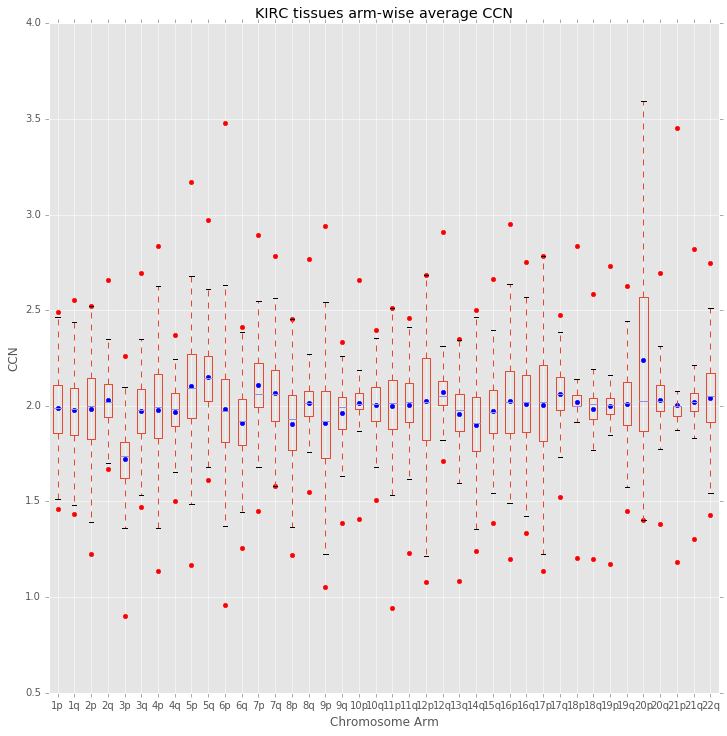

In [37]:
plot_arm_wise_averages(tissue_arm_data, prepend='KIRC')

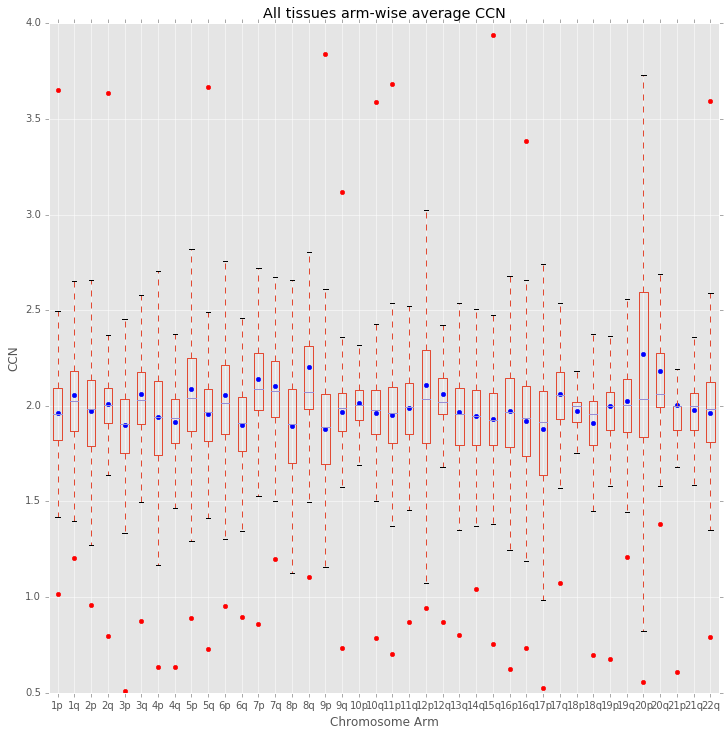

In [38]:
plot_arm_wise_averages(all_arm_data, prepend='All')

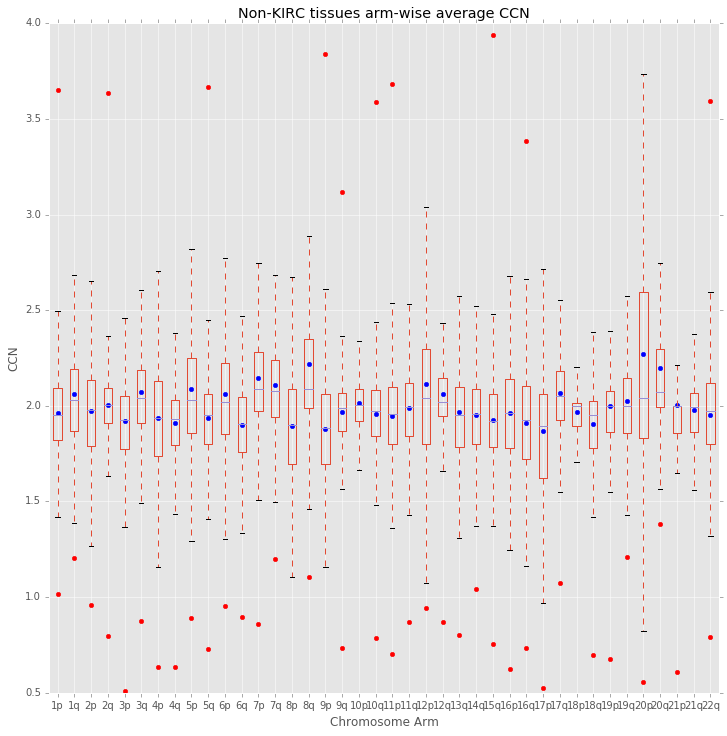

In [39]:
plot_arm_wise_averages(non_tissue_arm_data, prepend='Non-KIRC')

## p-test

In [40]:
arm = '21q'
a = tissue_arm_data[arm]
b = non_tissue_arm_data[arm]
ttest_ind(a, b, axis=0)

Ttest_indResult(statistic=3.7389743455018092, pvalue=0.00018705771531137537)

## Patients with loss of 3p

In [41]:
no3p = tissue_arm_data[tissue_arm_data['3p'] < 1.8].count()[0]
total = tissue_arm_data[['3p']].count()[0]
print('Ratio of patients with loss in 3p:\n', no3p, '/', total, '=', (no3p/total))

Ratio of patients with loss in 3p:
 294 / 417 = 0.705035971223


In [42]:
tissue_arm_data.corr(method='pearson', min_periods=1)

arm        1p        1q        2p        2q        3p        3q        4p  \
arm                                                                         
1p   1.000000  0.076168 -0.056499  0.124983  0.017958  0.077264  0.232794   
1q   0.076168  1.000000  0.024917  0.011656  0.057473 -0.067785  0.197770   
2p  -0.056499  0.024917  1.000000  0.198852 -0.037673 -0.116328  0.085230   
2q   0.124983  0.011656  0.198852  1.000000 -0.074159  0.090041  0.158139   
3p   0.017958  0.057473 -0.037673 -0.074159  1.000000  0.091384  0.016262   
3q   0.077264 -0.067785 -0.116328  0.090041  0.091384  1.000000  0.054028   
4p   0.232794  0.197770  0.085230  0.158139  0.016262  0.054028  1.000000   
4q   0.121978  0.043100  0.026866  0.071076  0.078527 -0.043255  0.192508   
5p  -0.034218  0.023751  0.165310  0.199570 -0.084455  0.021877  0.063527   
5q   0.029961  0.069007  0.030543  0.141609 -0.091186 -0.056344  0.037315   
6p   0.231961  0.008779 -0.025632 -0.015068  0.061692  0.080680  0.116752   
6q   0.067587 -0.068503  0.045484 -0.020422  0.117133  0.006910 -0.027146   
7p   0.043821 -0.035569 -0.006996  0.082597 -0.032674 -0.036834  0.031175   
7q   0.080864  0.021365  0.011221  0.129123  0.038025  0.009755  0.034894   
8p   0.136614  0.052120  0.065035  0.052677  0.090458  0.042635  0.168763   
8q   0.082911  0.076026  0.023099 -0.021123  0.102563  0.074686  0.054229   
9p   0.123178 -0.090804 -0.028892  0.087973  0.002816 -0.018751  0.099506   
9q   0.062047 -0.105331 -0.037571  0.077149  0.013913  0.095685  0.050206   
10p  0.059631  0.093932  0.026235  0.121119 -0.098398 -0.012222  0.125409   
10q  0.173177 -0.053015 -0.001740  0.110263  0.008178  0.065732  0.177923   
11p  0.035437  0.103448  0.073434  0.107933  0.026994  0.001191  0.101058   
11q  0.047466  0.009750  0.048633  0.131646  0.018899  0.039588  0.117952   
12p  0.156222  0.019188  0.019136  0.065900  0.083447  0.067649  0.078714   
12q  0.100392  0.123094  0.069410  0.098534  0.009577  0.052309  0.126629   
13q -0.014888  0.095774 -0.021818  0.102100  0.004690 -0.031370  0.065466   
14q  0.017840 -0.086550 -0.010041  0.046294  0.073785  0.062490  0.098248   
15q  0.124131  0.104746  0.082638  0.180737  0.019806  0.075941  0.152263   
16p  0.222336  0.051459  0.087733  0.139453 -0.012691  0.049667  0.171471   
16q  0.119225  0.044758  0.044596  0.181112 -0.010550  0.118884  0.121702   
17p  0.118716  0.033820  0.080359  0.085177  0.084113  0.012166  0.118985   
17q  0.064158  0.112896  0.030251  0.111203  0.117951  0.031392  0.126930   
18p  0.080468  0.022941  0.017555  0.216881  0.020086  0.063816  0.165409   
18q -0.090630 -0.080865  0.062612 -0.054106 -0.003909 -0.089515 -0.036891   
19p -0.011157  0.121222 -0.016438  0.078417 -0.014762 -0.000397  0.083658   
19q  0.182188  0.060473  0.060350  0.149296  0.028960  0.069897  0.152115   
20p -0.000181 -0.055130  0.025400  0.014190 -0.006104  0.071771  0.035128   
20q  0.041330  0.145674  0.002769  0.118116  0.109308  0.088132  0.142730   
21p  0.036231  0.012366 -0.049489  0.113003 -0.038311  0.095315  0.108473   
21q  0.109995  0.113153  0.040793  0.127350 -0.085478  0.018899  0.063114   
22q  0.164123  0.007604  0.130513  0.140208  0.023329  0.026079  0.154545   

arm        4q        5p        5q        6p        6q        7p        7q  \
arm                                                                         
1p   0.121978 -0.034218  0.029961  0.231961  0.067587  0.043821  0.080864   
1q   0.043100  0.023751  0.069007  0.008779 -0.068503 -0.035569  0.021365   
2p   0.026866  0.165310  0.030543 -0.025632  0.045484 -0.006996  0.011221   
2q   0.071076  0.199570  0.141609 -0.015068 -0.020422  0.082597  0.129123   
3p   0.078527 -0.084455 -0.091186  0.061692  0.117133 -0.032674  0.038025   
3q  -0.043255  0.021877 -0.056344  0.080680  0.006910 -0.036834  0.009755   
4p   0.192508  0.063527  0.037315  0.116752 -0.027146  0.031175  0.034894   
4q   1.000000 -0.030289 -0.024301  0.054027  0.034626 -0.109304 -0.04235

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, cross_val_score
import warnings
warnings.filterwarnings('ignore')

def get_tp(row):
    row['tp'] = int((row['pred']==1) and (row['actual']==1))
    row['tn'] = int((row['pred']==0) and (row['actual']==0))
    row['fp'] = int((row['pred']==1) and (row['actual']==0))
    row['fn'] = int((row['pred']==0) and (row['actual']==1))
    return row

def get_scores(predictions):
    tp = sum(predictions['tp'])
    tn = sum(predictions['tn'])
    fp = sum(predictions['fp'])
    fn = sum(predictions['fn'])
    total = len(predictions.index)

    print('accuracy:', (tp+tn)/float(total))
    print('error rate:', (fp+fn)/float(total))
    print('sensitivity:', tp/(tp+fn))
    print('specificity:', tn/(tn+fp))



def get_importances(gene_name, forest, X_train, y_train, prepend):
    importances = forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    rank = dict(zip(list(X_train.columns), importances))
    # Plot the feature importances of the forest
    imp = plt.figure()
    plt.bar(range(len(X_train.columns)), importances[indices], color="r", yerr=std[indices], align="center")
    plt.title("%s tissue %s feature importances" % (prepend, gene_name))
    plt.xticks(range(len(X_train.columns)), X_train.columns[indices])
    plt.xlim([-1, len(X_train.columns)])
    return imp

def get_roc(gene_name, forest, X_test, y_test, prepend):
    # Determine the false positive and true positive rates
    fpr, tpr, _ = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)
    print('ROC AUC: %0.2f' % roc_auc)
    # Plot of a ROC curve for a specific class
    roc = plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    return roc, roc_auc


def cross_validation(gene_name, forest, X_train, y_train, prepend):
    try:
        rf_scores = cross_val_score(forest, X_train, y_train.ravel(), cv=5, scoring='roc_auc')
        return rf_scores
    except:
        return [0]

        
def analyse_arms(arm_data, gene, arm_names, prepend):
    patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
    
    arm_data['mutation'] = arm_data['Patient'].isin(patients)
    print('Positive samples:', arm_data[arm_data['mutation']==True].count()[0])
    print('Negative samples:', arm_data[arm_data['mutation']==False].count()[0])
    X = arm_data[arm_names]
    y = arm_data[['mutation']]
    y = label_binarize(y, classes=[0,1])  # Binarize the output
    n_classes = y.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=1)
    

    
    from sklearn.naive_bayes import BernoulliNB
    nb_clf = BernoulliNB(binarize=True)

    from sklearn.cross_validation import cross_val_score
    nb_scores = cross_val_score(nb_clf, X_train, y_train.ravel(), scoring='roc_auc',cv=5)
    nb_score = nb_scores.mean()
    print ('NB - ', nb_scores, ' Mean: ', mean(nb_scores))
    
    from sklearn.svm import SVC
    svm_clf = SVC(kernel='poly', degree=3, cache_size=1000)
    svm_scores = cross_val_score(svm_clf, X_train, y_train.ravel(), scoring='roc_auc', cv=5)
    svm_score = svm_scores.mean()
    print('SVM -', svm_scores, ' Mean: ', mean(svm_scores))
    
    from sklearn.linear_model import LogisticRegression
    lr_clf = LogisticRegression()
    lr_scores = cross_val_score(lr_clf, X_train, y_train.ravel(), scoring='roc_auc', cv=5)
    lr_score = lr_scores.mean()
    print('LR -', lr_scores, ' Mean: ', mean(lr_scores))
    
    forest = RandomForestClassifier(n_estimators=1000, min_samples_leaf=30, random_state=1)    
    forest.fit(X_train, y_train)
    
    cv_scores = cross_validation(gene, forest, X_train, y_train, prepend)
    print('RF -', cv_scores, ' Mean: ', mean(cv_scores))
    roc, roc_auc = get_roc(gene, forest, X_test, y_test, prepend)
    roc.savefig('charts/%s_%s_roc.pdf' % (prepend, gene), bbox_inches='tight', format='pdf')
    roc.savefig('charts/%s_%s_roc.png' % (prepend, gene), bbox_inches='tight', format='png')
    plt.close(roc)
    
    importance = get_importances(gene, forest, X_train, y_train, prepend)
    importance.savefig('charts/%s_%s_importance.pdf' % (prepend, gene), bbox_inches='tight', format='pdf')
    importance.savefig('charts/%s_%s_importance.png' % (prepend, gene), bbox_inches='tight', format='png')
    plt.close(importance)
    
    
    return roc_auc

In [44]:
tissue_auc_dict = {}

for gene in gene_list:
    print(gene, '...')

    roc_auc = analyse_arms(arm_data=tissue_arm_data, gene=gene, arm_names=tissue_arm_names, prepend='KIRC')
    tissue_auc_dict[gene] = roc_auc

        


VHL ...
Positive samples: 165
Negative samples: 252
NB -  [ 0.4875      0.5         0.50601852  0.5         0.5       ]  Mean:  0.498703703704
SVM - [ 0.54444444  0.52407407  0.43981481  0.60588794  0.36182336]  Mean:  0.495208926876
LR - [ 0.55833333  0.49259259  0.4462963   0.58974359  0.33808167]  Mean:  0.485009496676
RF - [ 0.58425926  0.44907407  0.50555556  0.49097816  0.36847104]  Mean:  0.479667616334
ROC AUC: 0.49
PBRM1 ...
Positive samples: 78
Negative samples: 339
NB -  [ 0.49074074  0.5         0.48113208  0.5         0.5       ]  Mean:  0.494374563242
SVM - [ 0.62698413  0.72364672  0.67053701  0.5413643   0.59361393]  Mean:  0.631229218022
LR - [ 0.56613757  0.65954416  0.52394775  0.5065312   0.53991292]  Mean:  0.559214719592
RF - [ 0.63624339  0.61396011  0.62119013  0.57474601  0.55297533]  Mean:  0.599822993219
ROC AUC: 0.61
SETD2 ...
Positive samples: 28
Negative samples: 389
NB -  [ 0.5         0.49206349  0.49206349  0.49193548  0.5       ]  Mean:  0.4952124936
S

In [45]:
all_auc_dict = {}

for gene in gene_list:
    print(gene, '...')

    roc_auc = analyse_arms(arm_data=all_arm_data, gene=gene, arm_names=all_arm_names, prepend='All')
    all_auc_dict[gene] = roc_auc


VHL ...
Positive samples: 173
Negative samples: 4351
NB -  [ 0.47054598  0.47916667  0.48491379  0.48865969  0.48273381]  Mean:  0.481203987549
SVM - [ 0.80187808  0.79761905  0.85765599  0.81147373  0.78406989]  Mean:  0.810539346848
LR - [ 0.86073481  0.85981117  0.87864327  0.85283251  0.80678314]  Mean:  0.851760980378
RF - [ 0.88079844  0.82917693  0.88023399  0.83559113  0.85025694]  Mean:  0.855211485984
ROC AUC: 0.91
PBRM1 ...
Positive samples: 120
Negative samples: 4404
NB -  [ 0.46661932  0.49861506  0.52695313  0.49588068  0.47514205]  Mean:  0.492642045455
SVM - [ 0.63203125  0.58245739  0.6625      0.71455966  0.74678529]  Mean:  0.667666716507
LR - [ 0.74176136  0.7390625   0.66491477  0.72961648  0.8222189 ]  Mean:  0.739514802632
RF - [ 0.7318892   0.66690341  0.71079545  0.66754261  0.80465012]  Mean:  0.716356160287
ROC AUC: 0.71
SETD2 ...
Positive samples: 95
Negative samples: 4429
NB -  [ 0.46685472  0.47390691  0.51165961  0.53568406  0.51113238]  Mean:  0.49984753

In [46]:
non_tissue_auc_dict = {}

for gene in gene_list:
    print(gene, '...')

    roc_auc = analyse_arms(arm_data=non_tissue_arm_data, gene=gene, arm_names=non_tissue_arm_names, prepend='Non-KIRC')
    non_tissue_auc_dict[gene] = roc_auc


VHL ...
Positive samples: 8
Negative samples: 4099
NB -  [ 0.47332317  0.46646341  0.4695122   0.47175573  0.47022901]  Mean:  0.470256702662
SVM - [ 0.58917683  0.44817073  0.54268293  0.61221374  0.47175573]  Mean:  0.532799990691
LR - [ 0.76676829  0.38871951  0.67835366  0.58015267  0.32519084]  Mean:  0.547836994973
RF - [ 0.47560976  0.38033537  0.97103659  0.05801527  0.70534351]  Mean:  0.518068097189
ROC AUC: 0.08
PBRM1 ...
Positive samples: 42
Negative samples: 4065
NB -  [ 0.47311828  0.46615385  0.60813187  0.54494505  0.47      ]  Mean:  0.51246980976
SVM - [ 0.49901251  0.57516484  0.51252747  0.49054945  0.57051282]  Mean:  0.529553417397
LR - [ 0.69234145  0.50637363  0.45868132  0.56197802  0.64512821]  Mean:  0.572900524974
RF - [ 0.60785605  0.35142857  0.62461538  0.39142857  0.4725641 ]  Mean:  0.489578535136
ROC AUC: 0.47
SETD2 ...
Positive samples: 67
Negative samples: 4040
NB -  [ 0.55785604  0.46594427  0.46899225  0.51846371  0.46976744]  Mean:  0.496204741271

In [47]:
tissue_auc_dict

{'AKAP9': 0.61445783132530118,
 'ATM': 0.40853658536585369,
 'BAP1': 0.50092764378478671,
 'PBRM1': 0.61458333333333326,
 'PIK3CA': 0.49375000000000002,
 'PTEN': 0.68724279835390945,
 'RANBP2': 0.16049382716049382,
 'SETD2': 0.49671052631578949,
 'TP53': nan,
 'VHL': 0.49382716049382713}

In [48]:
non_tissue_auc_dict

{'AKAP9': 0.53057612898997175,
 'ATM': 0.40215909090909091,
 'BAP1': 0.66338663386633867,
 'PBRM1': 0.46759828009828008,
 'PIK3CA': 0.58421717171717169,
 'PTEN': 0.73058720420683609,
 'RANBP2': 0.40648148148148144,
 'SETD2': 0.47519475194751948,
 'TP53': 0.7430163284738216,
 'VHL': 0.081607795371498204}

In [49]:
all_auc_dict

{'AKAP9': 0.57519774011299429,
 'ATM': 0.43144825947487225,
 'BAP1': 0.67562319929850934,
 'PBRM1': 0.71067657832363718,
 'PIK3CA': 0.63715474839197883,
 'PTEN': 0.66441187523487411,
 'RANBP2': 0.45979067302596716,
 'SETD2': 0.46477052359405296,
 'TP53': 0.74032722899221626,
 'VHL': 0.91128023352793996}

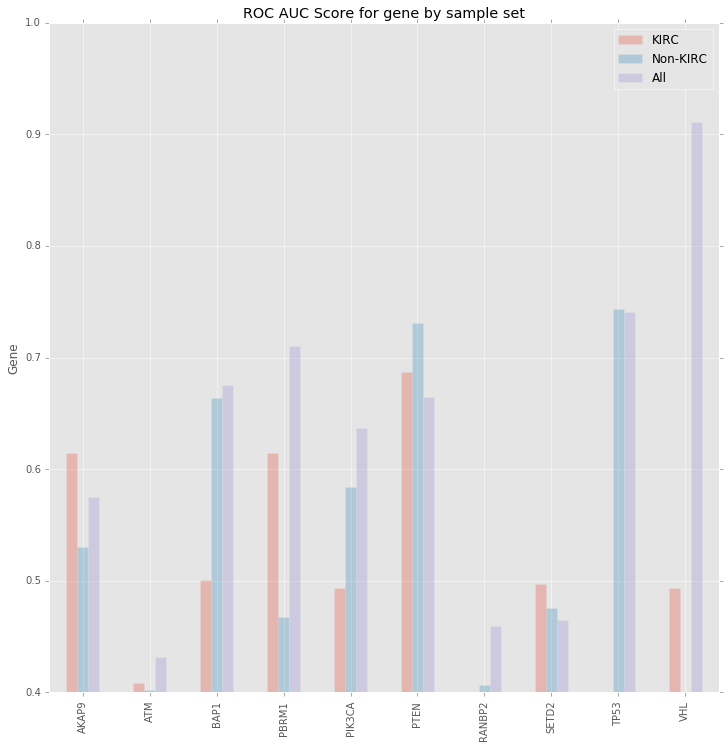

In [50]:

auc_scores = pd.DataFrame([tissue_auc_dict, non_tissue_auc_dict, all_auc_dict]).transpose()
auc_scores.columns =['KIRC','Non-KIRC','All']

fig, axes = plt.subplots(nrows=1, ncols=1)
auc_scores.plot(kind='bar', alpha=0.3, ax=axes)
axes.set_ylabel('ROC AUC')
axes.set_ylabel('Gene')
axes.set_ylim(0.4,1)
axes.set_title('ROC AUC Score for gene by sample set')
fig.savefig('charts/auc_box.pdf', bbox_inches='tight', format='pdf')
fig.savefig('charts/auc_box.png', bbox_inches='tight', format='png')

In [51]:
def arms_importance(arm_data, gene, arm_names):
    def get_importance(arm_data, gene, arm_names):
        import warnings
        warnings.filterwarnings('ignore')

        patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
        arm_data['mutation'] = arm_data['Patient'].isin(patients)
        X = arm_data[arm_names]
        y = arm_data[['mutation']]
        y = label_binarize(y, classes=[0,1])  # Binarize the output
        n_classes = y.shape[1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                            random_state=0)
        forest = RandomForestClassifier(n_estimators=1000, min_samples_leaf=30, random_state=1)
        forest.fit(X_train, y_train)
        importances = forest.feature_importances_
        return list(importances)        
    
    gene_arms_dict = {}
    for gene in genes['Gene']:
        gene_arms_dict[gene] = get_importance(arm_data, gene, arm_names)

    gene_arms = pd.DataFrame(gene_arms_dict,  dtype='float').transpose().reset_index()
    gene_arms.columns = ['gene'] + list(tissue_arm_data.columns[1:-1])
    pd.options.display.max_columns = 50
    
    gene_arms = gene_arms.transpose().reset_index()
    gene_arms.columns = gene_arms.ix[0,:]
    index_names = dict(zip(range(1,40+1), arm_names))
    gene_arms.rename(index=index_names, inplace=True)
    gene_arms = gene_arms.ix[1:,1:]
    
    return gene_arms
      


def make_heatmap(df,prepend,data_type):
    fig, axes = plt.subplots(nrows=1, ncols=1)
    sns.heatmap(df.astype(float),cmap="RdBu_r", ax=axes)# annot=True,
    axes.set_ylabel('Chromosome arm')
    axes.set_xlabel('Gene')
    axes.set_title('%s Tissue - Chromosome arm %s by gene' % (prepend, data_type))
    fig.savefig('charts/%s_%s_heatmap.pdf' % (prepend.lower(), data_type), bbox_inches='tight', format='pdf')
    fig.savefig('charts/%s_%s_heatmap_box.png' % (prepend.lower(), data_type), bbox_inches='tight', format='png')
    

In [52]:
tissue_importance = arms_importance(tissue_arm_data, gene, arm_names=all_arm_names)
#make_heatmap(tissue_importance,'KIRC','gini importance')
tissue_importance

0         AKAP9         ATM        BAP1       PBRM1      PIK3CA        PTEN  \
1p     0.069876  0.00648645   0.0147516   0.0155038   0.0317524   0.0146059   
1q   0.00695735   0.0160012   0.0381073   0.0106752  0.00424555   0.0304124   
2p     0.047922    0.012609   0.0117727   0.0159719   0.0178138   0.0117438   
2q    0.0252161  0.00759887   0.0146215   0.0120962   0.0962537   0.0115674   
3p   0.00706897   0.0155306  0.00883219   0.0311851  0.00684551   0.0345697   
3q     0.025833   0.0095539   0.0329129   0.0112468  0.00793836  0.00803148   
4p    0.0035925   0.0164364   0.0377142   0.0129892   0.0410703   0.0168991   
4q    0.0348734   0.0241458   0.0131507   0.0139326    0.011561   0.0310586   
5p    0.0107247   0.0370438   0.0208216   0.0149001  0.00644014   0.0244095   
5q    0.0152643   0.0319034   0.0397305   0.0128397   0.0194806   0.0378229   
6p    0.0142558   0.0103873   0.0334024   0.0207312  0.00803664    0.051902   
6q    0.0134658   0.0111194  0.00890016   0.0379943   0.0248712   0.0238126   
7p    0.0234538   0.0249128   0.0171201    0.052943  0.00932565  0.00741264   
7q    0.0607742   0.0101389    0.105104   0.0327084   0.0163437   0.0293669   
8p   0.00597758    0.030663   0.0422108   0.0095452   0.0649008   0.0190243   
8q    0.0144578   0.0205154    0.034435   0.0182446    0.100668   0.0180474   
9p    0.0363563   0.0202566   0.0306999   0.0251489   0.0261854  0.00453794   
9q    0.0205357   0.0305686   0.0157071   0.0153309  0.00791208   0.0200615   
10p   0.0109912   0.0362864   0.0225042   0.0631106   0.0152018   0.0306039   
10q   0.0104261   0.0606695  0.00984987   0.0498184   0.0207733   0.0400519   
11p   0.0589325  0.00773672   0.0395033   0.0451345   0.0574015  0.00616265   
11q   0.0127725    0.111401   0.0276228  0.00696391   0.0114425   0.0299373   
12p  0.00443463   0.0344992   0.0175296   0.0233573   0.0150714   0.0770519   
12q   0.0259152   0.0264437   0.0197257   0.0602809   0.0165786   0.0149428   
13q   0.0397239  0.00833183   0.0291496   0.0385599   0.0182096   0.0174763   
14q   0.0212369   0.0407516   0.0235911   0.0108769   0.0133025   0.0389465   
15q   0.0213895   0.0171663   0.0238974   0.0466798   0.0182901  0.00804641   
16p  0.00616851    0.019196   0.0111047   0.0243125   0.0175963   0.0478946   
16q   0.0521318  0.00554725   0.0376845  0.00850636   0.0340412    0.013376   
17p   0.0195215  0.00504599   0.0257321   0.0567961   0.0144429   0.0110237   
17q  0.00328082   0.0380143   0.0224707   0.0139003   0.0417502    0.015031   
18p  0.00748275    0.038782   0.0377706   0.0194319    0.045503   0.0116718   
18q    0.149434  0.00871311   0.0226324   0.0122921   0.0171302   0.0808453   
19p  0.00603575   0.0300265    0.015733   0.0126032   0.0433177   0.0339261   
19q    0.052685   0.0207394   0.0228679  0.00792458  0.00684508   0.0390029   
20p  0.00967018   0.0252077   0.0152555   0.0338445   0.0308365   0.0269854   
20q   0.0316457      0.0164  0.00915732   0.0532368   0.0126067   0.0155317   
21p  0.00763773  0.00125786  0.00743785  0.00418969   0.0133552   0.0156344   
21q  0.00679758   0.0315072   0.0137719   0.0145759   0.0200904   0.0235657   
22q  0.00308073   0.0804057   0.0250135   0.0296168   0.0135688  0.00700539   

0        RANBP2       SETD2        TP53         VHL  
1p     0.017268   0.0464406   0.0334857   0.0153997  
1q    0.0534026   0.0073823   0.0141703    0.127204  
2p    0.0333467    0.015662   0.0083917   0.0199853  
2q    0.0247878   0.0162623   0.0668976   0.0128519  
3p    0.0159541  0.00956031   0.0229769   0.0203575  
3q    0.0555113   0.0103782   0.0147634   0.0265446  
4p    0.0247328   0.0136954   0.0405066   0.0196086  
4q    0.0236463     0.10062   0.0185043   0.0368003  
5p    0.0452359   0.0174051  0.00540598   0.0198389  
5q   0.00864178   0.0171369   0.0179633   0.0214648  
6p   0.00537401   0.0581245   0.0405687    0.017896  
6q    0.0534139   0.0413974   0.0445406   0.0304028  
7p    0.0257008   0.0303013   0.0139626   0.0406586  
7q  

In [53]:
gene_mean_dict = {}
def arms_sm(arm_data, gene, arm_names):
    def get_gene_mean(arm_data, gene, arm_names):
        import warnings
        warnings.filterwarnings('ignore')
        patients = all_sm[all_sm['Hugo_Symbol'] == gene]['Patient'].unique()
        arm_data['mutation'] = arm_data['Patient'].isin(patients)
    #     print (arm_data['mutation'])
    #     print(arm_data[arm_data['mutation']==True])
        gene_mean_dict[gene] = list(arm_data[arm_data['mutation']==True][arm_names].apply(mean, axis=0))


    for gene in genes['Gene']:
        get_gene_mean(arm_data, gene, arm_names=all_arm_names)
    
    gene_mean = pd.DataFrame(gene_mean_dict).transpose().reset_index()
    gene_mean.columns = ['gene'] + list(arm_data.columns[1:-1])
    pd.options.display.max_columns = 50
    
    gene_mean = gene_mean.transpose().reset_index()
    gene_mean.columns = gene_mean.ix[0,:]
    index_names = dict(zip(range(1,40+1), arm_names))
    gene_mean.rename(index=index_names, inplace=True)
    gene_mean = gene_mean.ix[1:,1:]
    
    return gene_mean

def get_ccn(x):
    if type(x) == float:
        return (2**x)*2
    else:
        return x